# Assignment for FAIP lecture "Reinforcement Learning"

In this assignment you will implement tabular Q-learning (from the 2nd video) and test it in the MountainCar environment (from the 1st video). To pass this assignment, you must make a serious attempt to solve all 7 tasks (your answer does not have to be correct, but you must show you tried) and achieve at least 7 of the 11 possible points. You should not spend much more than 4-5 hours on the assignment.

### Tasks you must solve:
- [Task 1: identify the MDP (1 point)](#mdp)
- [Task 2: familiarize yourself with Q-learning (1 point)](#value)
- [Task 3: implement Q-learning (2 points)](#TD)
- [Task 4: implement the learning loop of RL (2 points)](#RL)
- [Task 5: test your implementation (1 point)](#test)
- [Task 6: resolution trade-off (2 points)](#res)
- [Task 7: optimistic exploration (2 points)](#exp)

### Literature
- Richard S. Sutton and Andrew G. Barto. Reinforcement Learning: An Introduction. The MIT Press, second edition, 2018, [online version](http://incompleteideas.net/book/the-book-2nd.html).

The following class`MountainCar` specifies a variant of the classical `MountainCar-v0` environment, where the reward is 1 if the goal on the top of the right hill is reached and 0 otherwise. You can start a new episode with `reset()` and execute an `action` with `step(action)`.
![An animation of the MountainCar environment in action](https://user-images.githubusercontent.com/10624937/42135605-ba0e5f2c-7d12-11e8-9578-86d74e0976f8.gif)

In [1]:
!pip install gymnasium 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import gymnasium as gym 

class MountainCar (gym.Wrapper):
    def __init__(self):
        super().__init__(env=gym.make('MountainCar-v0'))
        self._elapsed_steps = self.env._elapsed_steps
        
    def reset(self):
        """ Starts a new episode and returns the first state. """
        self._elapsed_steps = 0
        return self.env.reset()[0]
    
    def step(self, action):
        """ Executes an `action` in the current state. Returns the `next_state`, the received `reward`, 
            a boolean `done` indicating whether the episode is finished (terminal or timeout), and 
            a boolean `terminal` indicating whether a `done` episode ended in a terminal state."""
        next_state, _, terminal, truncated, _ = super().step(action)
        self._elapsed_steps += 1
        done = truncated or terminal
        reward = 1 if terminal else 0
        return next_state, reward, done, terminal

## Task 1: identify the MDP (1 point) <a id=mdp></a>

The reinforcement learning algorithm interacts with the above class `MountainCar` only through 2 methods. Look up the definition of a Markov Decision Process (MDP) and indicate which inputs/outputs of `reset()` and `step()` are corresponding to which elements of the MDP, and from/by which distribution/function they are drawn/determined.

*See Sections 3.1 to 3.3 in Suttan and Barto (2018) for more information on MDP, reward and return.*

- $ MDP = \langle S, A, \rho, P, r \rangle $
- `reset()`:
    - output is initial state $s_0 \sim \rho, s_0 \in S$
- `step()`:
    - input `action` $a_t \in A$
    - output `nexts state` $s_{t+1} \in S$
    - output `reward` $r(s_t,a_t); s_t \in S,a_t \in A  $
    - output `done` not a MDP element
    - output `terminal` not a MDP element

## Task 2: familiarize yourself with Q-learning (1 point) <a id=value></a>

Read the lecture slides of video 2 again (and watch the video if it helps). Try to understand the "temporal difference" update rule of tabular Q-learning. You will use the class `ValueFunction` below later to store a table of Q-values. Make sure you know how to read and write Q-values using that class before you continue.

*See Section 6.5 in Sutton and Barto (2018) for more details on Q-learning.*

In [3]:
import numpy as np
from collections.abc import Iterable

class ValueFunction:
    """ Defines a tabular Q-value function for a given 'env'ironment and
        optionally a resolution (int or Iterable of int) and
        optionally some 'state_bounds' (list of 2-tuples, one for each state dimension).
        
        For example, defining 'q = ValueFunction(env)' allows to: 
        set values with 
            'q[state] = [value_1, ..., value_num_actions]' or 
            'q[state, action] = single_value', and 
        get values with 
            'q[state]' returns an array with the values of all actions or
            'q[state, action]' returns the value of the given 'action'."""
    def __init__(self, env, resolution=50, state_bounds=None, init_value=0.0):
        # derive the action space
        assert isinstance(env.action_space, gym.spaces.Discrete), "The environment must have discrete actions."
        self.num_actions = env.action_space.n
        # derive the the state space
        if state_bounds is None:
            self.bounds = [(l, h) for l,h in zip(env.observation_space.low, env.observation_space.high)]
        else:
            self.bounds = state_bounds
        self.resolution = resolution if isinstance(resolution, Iterable) else [resolution for _ in self.bounds]
        assert len(self.resolution) == len(self.bounds), \
                "The resolution and state bounds must be consistent with the given environment."
        # define other properties
        self.eps = 1E-7
        # define the lookup table for the values
        self.shape = (*self.resolution, self.num_actions)
        self.val = np.ones(self.shape) * (init_value)  # + self.eps)
        
    def state_bin(self, state):
        """ Find the correct bin in 'self.count' for one state. """
        return tuple([int((x - l) / (h - l + self.eps) * r) for x, (l, h), r in zip(state, self.bounds, self.resolution)])
        
    def __setitem__(self, key, newvalue):
        assert isinstance(key, Iterable) and len(key) > 0, \
                    "x[state] = actions or x[state, action] = value"
        if isinstance(key[0], Iterable) and len(key) > 1:
            assert key[1] >= 0 and key[1] < self.num_actions, \
                    "illegal action %u, must be between 0 and %u" % (key[1], self.num_actions-1)
            self.val[self.state_bin(key[0])][key[1]] = newvalue
        else:
            assert len(newvalue) == self.num_actions, \
                    "wrong size %u of value-vector, must be %u" % (len(newvalue), self.num_actions)
            self.val[self.state_bin(key)] = newvalue
        
        
    def __getitem__(self, key):
        assert isinstance(key, Iterable) and len(key) > 0
        if isinstance(key[0], Iterable) and len(key) > 1:
            return self.val[self.state_bin(key[0])][key[1]]
        else:
            return self.val[self.state_bin(key)]

To show that you can use `ValueFunction`, fill in the missing 4 lines below: 

In [4]:
q = ValueFunction(env=MountainCar(), resolution=5, init_value=1)

# TODO: overwrite the Q-value of state (0.5,0) and action 1 with the value 2
q[[0.5,0],1] = 2
# TODO: print all Q-values in state (0.5,0) 
print(q[0.5,0])
# TODO: print the Q-values of action 1 in state(0.5, 0.05)
print(q[[0.5,0.05],1])
# TODO: print all Q-values of state (0.4, 0)
print(q[0.4,0])

[1. 2. 1.]
1.0
[1. 2. 1.]


Explain in the field below why the Q-values of states $s=(0.5, 0)$ and $s'=(0.4, 0)$ are identical, even though $s'$ has never been changed. 

***Explanation:*** 
The reason why these Q values are identical is due to the discretization of the state space of the environment. This way, for similar states, the Q value is approximated to the nearest neighbor,hence the similar value.

## Task 3: implement Q-learning (2 points) <a id=TD></a>
Look up the lecture slide "tabular Q-learning" and implement the temporal difference update rule in the method `learn` of the given class `QLearningAgent`. The method receives a starting `state`, an `action` that is executed in `state`, a `next_state` after execution of `action`, a received `reward` for that transition and a boolean `terminal` that is `True` if `next_state` is a terminal state (i.e. the goal of MountainCar). For full points, make sure the update is correct in `terminal` states, i.e., after the transition into `next_state`, no further rewards are received and accounted for in the learned Q-values.

*See Section 6.5 in Sutton and Barto (2018) for more details on Q-learning.*

In [5]:
class QLearningAgent:
    def __init__(self, env, alpha=0.5, gamma=0.99, resolution=50, init_value=1.0):
        self.q = ValueFunction(env, resolution=resolution, init_value=init_value)
        self.alpha = alpha
        self.gamma = gamma
        
    def choose(self, state):
        return np.argmax(self.q[state])
    
    def learn(self, state, action, next_state, reward, terminal):
        # TODO: update the Q-values in `self.q` here
        Qsa = self.q[state,action]
        Qsa_next_max = max(self.q[next_state])
        gamma = self.gamma
        alpha = self.alpha
        
        self.q[state,action] = Qsa + alpha*(reward + gamma*Qsa_next_max*(not terminal) - Qsa)
        
        pass

## Task 4: implement the learning loop of RL (2 points) <a id=RL></a>

Extend the method `train()` of the following class `RLExperiment`, which is supposed to learn the `MountainCar` environment using the above `QLearningAgent`. The class also manages experiment results and plots learning curves, q-values and policies in regular intervals. Due to its complexity, it is not necessary that you fully understand it, you must just implement the `train_episode()` method (no other methods need to be modified), similar to the lecture slides.

*See Section 3.1 in Sutton and Barto (2018) for more details on the agent-environment interface.*

In [6]:
from IPython import display
import matplotlib.pyplot as plt
import pylab as pl

class RLExperiment:
    """ Main class that initializes, runs and plots an RL experiment. """
    
    def __init__(self, alpha=0.5, gamma=0.95, resolution=50, init_value=1, plot_interval=50):
        self.plot_results = plot_interval > 0
        self.plot_interval = plot_interval
        self.env = MountainCar()
        self.max_episode_length = self.env.spec.max_episode_steps
        self.init_value = init_value
        self.agent = QLearningAgent(self.env, alpha=alpha, gamma=gamma, resolution=resolution, init_value=init_value)
        self.episode_returns = []
        self.env_steps = []
        
    def _plot_states(self, image, colormap='jet', ticks=None):
        """ Internal method that plots a colorplot of some image. 
             You do not need to understand (or change) the details of this method. """
        # colorplot of 'image' and a white finish line
        pl.imshow(np.transpose(np.flip(image, axis=1), (1, 0)), cmap=colormap)
        idx = self.agent.q.state_bin((0.5, 0))
        pl.plot([idx[0]-0.5, idx[0]-0.5], [0, image.shape[1]-1], 'w:')
        # set the axis
        idx = self.agent.q.state_bin((-0.5, 0))
        pl.xticks([-0.5, idx[0], self.agent.q.val.shape[0] - 0.5], [-1.2, -0.5, 0.6])
        pl.xlabel('position')
        pl.yticks([-0.5, idx[1], self.agent.q.val.shape[1] - 0.5], [0.07, 0, -0.07])
        pl.ylabel('velocity')
        # add a colorbar with the given 'colormap' (and eventually with the defined 'ticks')
        if ticks is None:
            pl.colorbar()
        else:
            cbar = pl.colorbar(ticks=[i - 1 for i in range(len(ticks))])
            cbar.ax.set_yticklabels(ticks)  # vertically oriented colorbar

    def _plot_training(self, update=False):
        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting). 
            You do not need to understand (or change) the details of this method. """ 
        # Smooth curves
        window = max(int(len(self.episode_returns) / 50), 10)
        if len(self.episode_returns) < window + 2: return
        returns = np.convolve(self.episode_returns, np.ones(window)/window, 'valid')
        env_steps = np.convolve(self.env_steps, np.ones(window)/window, 'valid')
        # Create plot
        colors = ['b', 'g', 'r']
        fig = plt.gcf()
        fig.set_size_inches(16, 4)
        plt.clf()
        # Plot the returns in the left subplot
        pl.subplot(1, 3, 1)
        pl.plot(env_steps, returns, colors[0])
        pl.xlabel('environment steps')
        pl.ylabel('averaged episode return')
        # Plot the value function in the second plot
        pl.subplot(1, 3, 2)
        self._plot_states(self.agent.q.val.max(axis=-1))
        pl.title('values')
        # Plot the policy in the third plot
        pl.subplot(1, 3, 3)
        policy = np.argmax(self.agent.q.val, axis=-1)
        policy[(self.agent.q.val == self.init_value).all(axis=-1)] = -1
        self._plot_states(policy, colormap='gnuplot', ticks=['unvisited', 'left', 'none', 'right'])
        pl.title('policy')
        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())
            
    def close(self):
        """ Closes the environment (free resources). Do not change this method. """
        self.env.close()
        
    def train(self, num_episodes=float('inf'), max_env_steps=float('inf')):
        """ Trains a RL agent for `num_episodes` or until `max_env_steps`. 
            Do not change this method! """
        env_steps, episode = 0, 0
        while episode < num_episodes and env_steps < max_env_steps:
            episode_return = self.train_episode()
            # increase counters
            env_steps += self.env._elapsed_steps
            episode += 1
            # remember results
            self.episode_returns.append(episode_return)
            self.env_steps.append(env_steps)
            # plot the loss, values and policy
            if self.plot_results and (episode + 1) % self.plot_interval == 0: 
                self._plot_training(update=True)
        if self.plot_results:
            self._plot_training(update=False)
            
    def train_episode(self):
        """ Run and train the agent with one episode. This method must be completed by you! """
        # TODO: start a new episode and run it until the environemnt returns `done==True`.
        # - update the Q-learning agent `self.agent` in every step
        # - the function must return the sum of all experienced rewards during this episode
        s_next = self.env.reset()
        done = 0
        r_sum = 0
        while not done:
            s, a = s_next, self.agent.choose(s_next)
            s_next, r, done, terminal = self.env.step(a)
            self.agent.learn(s, a, s_next, r, terminal)
            r_sum +=  r
            
        return r_sum

## Task 5: test your implementation (1 point)  <a id=test></a>

Running the following code segment runs Q-learning for 1 million environment steps using the following parameters:
- learning rate `alpha=0.5`
- discount factor `gamma=0.99`
- discretization `resolution=31`
- table initialization `init_val=1`

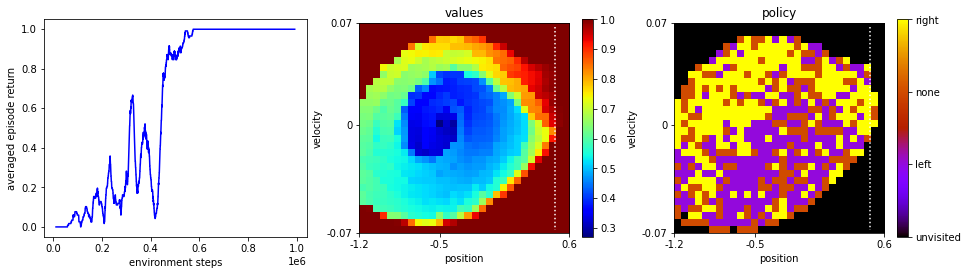

In [7]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=30, init_value=1)
ex.train(max_env_steps=1E6)

## Task 6: resolution trade-off (2 points) <a id=res></a>

Play around with the `resolution` parameter of `RLExperiment`. What is the smallest resolution with which you can still learn the task? Does this resolution learn in fewer or more environmental steps? Is the final performance (episode return) the same? Show the final plots of ***at least 3*** examples that demonstrate your findings.
Also describe your observations, conclusions and answers to the above questions (in few words) in the field below.

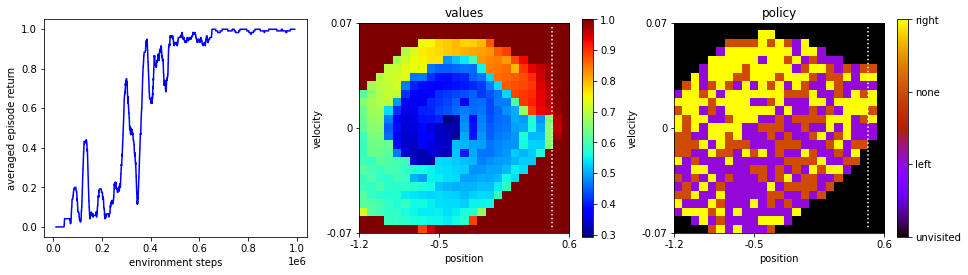

In [8]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=25, init_value=1)
ex.train(max_env_steps=1E6)

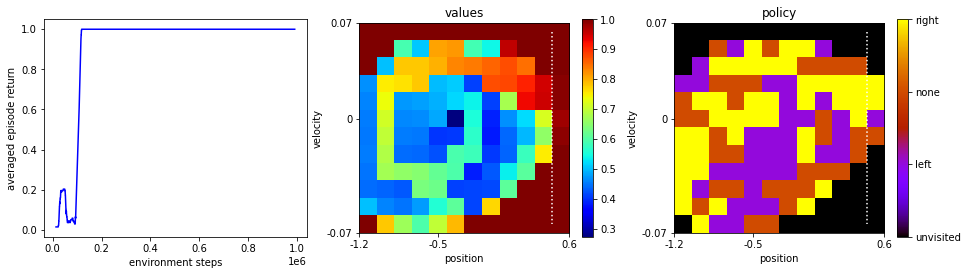

In [9]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=12, init_value=1)
ex.train(max_env_steps=1E6)

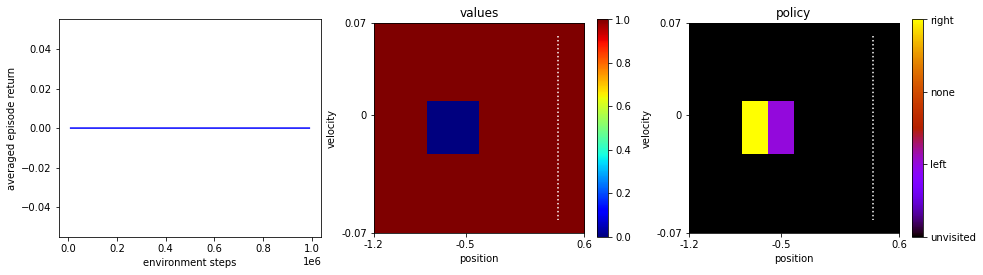

In [10]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=8, init_value=1)
ex.train(max_env_steps=1E6)

***Observations:*** 

The smallest resultion that still allowed the agent to learn the task was `resolution = 12`. Using a lower resolution also seemeed to reduce the number of steps, which makes sense given the smaller amout of possible states due to the more coarse discretization, thus allowing the agent to explore the space faster. In addition, the final performance was also the same. 

## Task 7: optimistic exploration (2 points) <a id=exp></a>

In this task you will investigate the exploration behavior of the Q-learning agent. Frist, run the configuration of Task 4 *without optimistic initialization*, that is, with `init_value=0`.

*See Section 2.6 in Sutton and Barto (2018) for more details on optimistic intialization.*

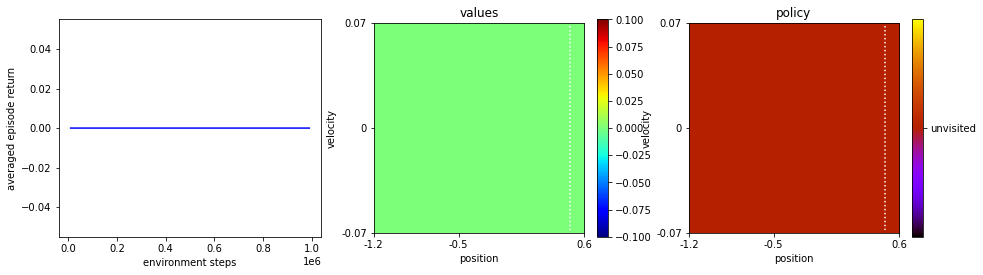

In [11]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=31, init_value=0)
ex.train(max_env_steps=1E6)

The above agent does not learn, because it does not explore the environment and therefore Q-learning does not converge to the optimal value function. Next, play around with the initial table value. Starting with `init_value=0.1`, how well does the Q-value agent learn for varying `init_value`? Is the final performance the same? Is that performance learned in fewer environmental steps? Show the final plots of ***at least 3*** expamples.
Also describe your observations, conclusions and answers to the above questions (in few words) in the field below.

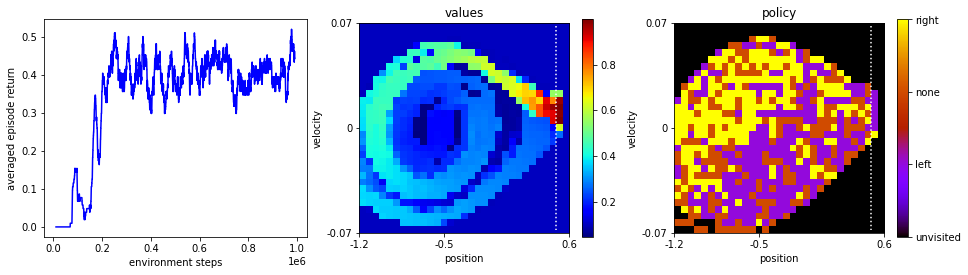

In [12]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=31, init_value=0.1)
ex.train(max_env_steps=1E6)

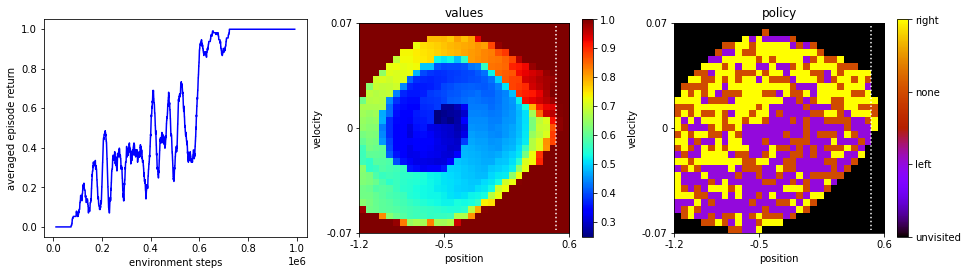

In [13]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=31, init_value=1)
ex.train(max_env_steps=1E6)

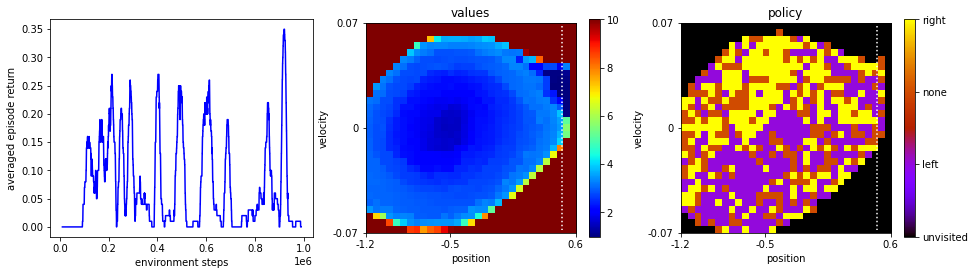

In [14]:
ex = RLExperiment(alpha=0.5, gamma=0.99, resolution=31, init_value=10)
ex.train(max_env_steps=1E6)

***Observations:***

From the computed results, it seems like there is an optimal value for the optimistic initialization, given that for both extremely large or small values the agent does not seem to learn the optimal policy, resulting in a low final performance. This could be explained by the fact that if the Q* values are initialized with values too far from the actual optimum, the algorithm will required more iterations to converge or in some cases, the maximum number of evaluations is reached before convergence.  